In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectorMixin
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings("ignore")

In [32]:
class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self.feature_names = feature_names
        self.bounds_ = {}
        self.medians_ = {}

    def fit(self, X, y=None):

        if isinstance(X, np.ndarray):
            X_df = pd.DataFrame(X, columns=self.feature_names)
        elif isinstance(X, pd.DataFrame):
            X_df = X.reindex(columns=self.feature_names).copy()
        else:
            raise ValueError("X must be DataFrame or ndarray")

        for col in self.feature_names:
            if col not in X_df.columns:
                continue
            if not pd.api.types.is_numeric_dtype(X_df[col]):
                continue
            if X_df[col].isna().all():
                continue

            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1

            if IQR == 0:
                continue

            self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
            self.medians_[col] = X_df[col].median()

        return self

    def transform(self, X):
        check_is_fitted(self, ['bounds_', 'medians_'])

        if isinstance(X, np.ndarray):
            X_df = pd.DataFrame(X, columns=self.feature_names)
        elif isinstance(X, pd.DataFrame):
            X_df = X.reindex(columns=self.feature_names).copy()
        else:
            raise ValueError("X must be DataFrame or ndarray")

        for col, (low, high) in self.bounds_.items():
            mask = (X_df[col] < low) | (X_df[col] > high)
            X_df.loc[mask, col] = self.medians_[col]

        return X_df.to_numpy()


In [33]:
class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):

    def __init__(self, variance_percentile=0.10, corr_threshold=0.7):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold

    def fit(self, X, y):

        X, y = check_X_y(X, y, ensure_all_finite='allow-nan')
        self.n_features_in_ = X.shape[1]

        df = pd.DataFrame(X)

        variances = df.var()
        var_threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > var_threshold

        correlations = df.corrwith(pd.Series(y)).abs().fillna(0)
        high_corr_mask = correlations > self.corr_threshold

        final_mask = high_variance_mask | high_corr_mask
        self.selected_indices_ = np.where(final_mask.values)[0]

        if len(self.selected_indices_) == 0:
            self.selected_indices_ = np.arange(self.n_features_in_)

        return self

    def _get_support_mask(self):
        check_is_fitted(self, 'selected_indices_')
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

    def get_support(self, indices=False):
        check_is_fitted(self, 'selected_indices_')
        if indices:
            return np.array(self.selected_indices_)
        return self._get_support_mask()

    def transform(self, X):
        check_is_fitted(self, 'selected_indices_')
        X = check_array(X, ensure_all_finite='allow-nan')

        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X has {X.shape[1]} features, but expected {self.n_features_in_}"
            )

        return X[:, self._get_support_mask()]

In [34]:
## Clean Dataset
def clean_dataset(col):
    col = col.strip().lower()
    col = re.sub(r'[\^]', "_", col)
    col = col.strip("_")
    return col

In [35]:
df = fetch_openml(name="house_prices", as_frame=True).frame

In [36]:
df.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1274,1275,50,RL,53.0,5362,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,139000
699,700,120,FV,59.0,4282,Pave,Pave,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,196000
1245,1246,80,RL,78.0,12090,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Abnorml,178000


In [37]:
df.shape

(1460, 81)

In [38]:
df.select_dtypes(np.number).head(1)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500


In [39]:
cat_df = df.select_dtypes(include="object").head(1)

In [40]:
df1 = pd.get_dummies(df[cat_df.columns], drop_first=True)


In [41]:
df1.corr()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
MSZoning_FV,1.000000,-0.022722,-0.416608,-0.090435,0.013866,0.445741,0.023612,-0.017926,0.074564,-0.040649,...,-0.012654,-0.012654,0.198831,-0.009795,-0.151069,-0.011314,-0.019651,-0.025439,-0.124064,0.195066
MSZoning_RH,-0.022722,1.000000,-0.203158,-0.044101,0.006762,0.061752,0.021930,-0.008742,0.039092,0.052529,...,-0.006171,-0.006171,-0.031785,-0.004776,0.021659,-0.005517,-0.009583,-0.012405,-0.036497,-0.032210
MSZoning_RL,-0.416608,-0.203158,1.000000,-0.808585,0.045348,-0.267166,0.027175,0.022698,-0.268764,0.023808,...,0.001671,-0.027031,0.004972,0.023511,0.015608,0.027158,-0.008548,-0.025492,0.046098,0.002730
MSZoning_RM,-0.090435,-0.044101,-0.808585,1.000000,-0.003127,0.010214,-0.047949,-0.011491,0.242838,-0.026057,...,0.008337,0.041233,-0.105674,-0.019011,0.078404,-0.021959,0.004432,0.049827,0.050686,-0.100724
Street_Pave,0.013866,0.006762,0.045348,-0.003127,1.000000,0.010919,-0.053886,0.005335,-0.004414,-0.046774,...,0.003766,0.003766,0.019397,0.002915,0.006539,0.003367,-0.112734,0.007571,-0.002140,0.019657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,-0.011314,-0.005517,0.027158,-0.021959,0.003367,-0.008909,-0.008909,-0.004353,0.012666,-0.009870,...,-0.003073,-0.003073,-0.015827,-0.002378,0.020457,1.000000,-0.004772,-0.006177,-0.112080,-0.016038
SaleCondition_Alloca,-0.019651,-0.009583,-0.008548,0.004432,-0.112734,-0.015474,-0.015474,-0.007560,0.037744,0.024571,...,-0.005337,-0.005337,-0.027489,-0.004131,0.035530,-0.004772,1.000000,-0.010729,-0.194663,-0.027856
SaleCondition_Family,-0.025439,-0.012405,-0.025492,0.049827,0.007571,-0.020032,-0.020032,0.061658,0.028480,0.042610,...,-0.006909,-0.006909,-0.035587,-0.005348,0.028599,-0.006177,-0.010729,1.000000,-0.252006,-0.036062
SaleCondition_Normal,-0.124064,-0.036497,0.046098,0.050686,-0.002140,-0.060962,0.014667,-0.026089,-0.003730,-0.059157,...,-0.003139,0.027414,-0.645698,-0.097031,0.634322,-0.112080,-0.194663,-0.252006,1.000000,-0.654323


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [44]:
## Check duplicate
df.duplicated().sum()

np.int64(0)

In [45]:
for col in df.columns:
    print(col, " : ", df[col].nunique())

Id  :  1460
MSSubClass  :  15
MSZoning  :  5
LotFrontage  :  110
LotArea  :  1073
Street  :  2
Alley  :  2
LotShape  :  4
LandContour  :  4
Utilities  :  2
LotConfig  :  5
LandSlope  :  3
Neighborhood  :  25
Condition1  :  9
Condition2  :  8
BldgType  :  5
HouseStyle  :  8
OverallQual  :  10
OverallCond  :  9
YearBuilt  :  112
YearRemodAdd  :  61
RoofStyle  :  6
RoofMatl  :  8
Exterior1st  :  15
Exterior2nd  :  16
MasVnrType  :  4
MasVnrArea  :  327
ExterQual  :  4
ExterCond  :  5
Foundation  :  6
BsmtQual  :  4
BsmtCond  :  4
BsmtExposure  :  4
BsmtFinType1  :  6
BsmtFinSF1  :  637
BsmtFinType2  :  6
BsmtFinSF2  :  144
BsmtUnfSF  :  780
TotalBsmtSF  :  721
Heating  :  6
HeatingQC  :  5
CentralAir  :  2
Electrical  :  5
1stFlrSF  :  753
2ndFlrSF  :  417
LowQualFinSF  :  24
GrLivArea  :  861
BsmtFullBath  :  4
BsmtHalfBath  :  3
FullBath  :  4
HalfBath  :  3
BedroomAbvGr  :  8
KitchenAbvGr  :  4
KitchenQual  :  4
TotRmsAbvGrd  :  12
Functional  :  7
Fireplaces  :  4
FireplaceQu  :  5
Ga

In [46]:
X = df.drop(df[["SalePrice"]], axis=1)
Y = df["SalePrice"]

In [47]:
Y = pd.DataFrame(Y)

In [48]:
## Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
type(Y_train)

pandas.core.frame.DataFrame

In [50]:
numerical_cols = X_train.select_dtypes(np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

In [51]:
skewness = X_train[numerical_cols].apply(lambda x:x.skew())
skew_threshold = 0.05

In [52]:
skew_cols = skewness[skewness >= skew_threshold].index.tolist()
norm_cols = list(set(numerical_cols) - set(skew_cols))

In [53]:
skew_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutliersToMedianTransformer(feature_names=skew_cols)),
    ('SS', StandardScaler())
])

In [54]:
norm_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('outliers', OutliersToMedianTransformer(feature_names=norm_cols)),
    ('MMS', MinMaxScaler())
])

In [55]:
cat_subpipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [56]:
preprocessor = ColumnTransformer([
    ('skew', skew_subpipeline, skew_cols),
    ('norm', norm_subpipeline, norm_cols),
    ('cat', cat_subpipeline, categorical_cols)
], remainder='drop')

In [57]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Feature_selection', AdvancedFeatureSelector(variance_percentile=0.10, corr_threshold=0.7)),
    # ('LogisticRegression', LogisticRegression())
    ('DTC', DecisionTreeRegressor(max_depth=5, max_features=30, min_samples_leaf=30))
])

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("==== Training Base Model ====")

final_pipeline.fit(X_train, Y_train)

y_pred = final_pipeline.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)        # ✅ SAFE FIX
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Base Model RMSE: {rmse:,.2f}")
print(f"Base Model MAE:  {mae:,.2f}")
print(f"Base Model R²:   {r2:.4f}")

==== Training Base Model ====
Base Model RMSE: 56,043.25
Base Model MAE:  35,968.42
Base Model R²:   0.5905


In [75]:
final_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('Feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skew', ...), ('norm', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
print("Model accuracy: ", final_pipeline.score(X_train, Y_train)*100)

Model accuracy:  73.73182808727996


In [81]:
from sklearn.metrics import r2_score

y_train_pred = final_pipeline.predict(X_train)
y_test_pred  = final_pipeline.predict(X_test)

print("Train R2:", r2_score(Y_train, y_train_pred))
print("Test  R2:", r2_score(Y_test, y_test_pred))


Train R2: 0.7373182808727996
Test  R2: 0.7046714546192347


In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'DTC__max_depth': [5, 10, 20, 30, None],
    'DTC__min_samples_split': [2, 5, 10, 20],
    'DTC__min_samples_leaf': [1, 2, 5, 10],
    'DTC__max_features': ['sqrt', 'log2', None]
}


grid = GridSearchCV(
    final_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, Y_train)

print("Best CV R2:", grid.best_score_)
print("Best Params:", grid.best_params_)




Best CV R2: 0.7365857948722809
Best Params: {'DTC__max_depth': 10, 'DTC__max_features': None, 'DTC__min_samples_leaf': 10, 'DTC__min_samples_split': 10}


In [88]:
print(final_pipeline.named_steps.keys())
# Output example: dict_keys(['Outliers', 'Feature_selection', 'DTC'])

dict_keys(['preprocessor', 'Feature_selection', 'DTC'])


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))  # manual RMSE
mae = mean_absolute_error(Y_test, y_test_pred)

print("Train R2:", r2_score(Y_train, y_train_pred))
print("Test R2:", r2_score(Y_test, y_test_pred))
print("Test RMSE:", rmse)
print("Test MAE:", mae)


Train R2: 0.8731905545442153
Test R2: 0.8225700156502136
Test RMSE: 36890.999700454966
Test MAE: 23476.530931704216


In [96]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'DTC__max_depth': [5, 10, 20, 30, None],
    'DTC__min_samples_split': randint(2, 50),  # random int from 2 to 49
    'DTC__min_samples_leaf': randint(1, 20),   # random int from 1 to 19
    'DTC__max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=final_pipeline,
    param_distributions=param_dist,
    n_iter=50,           # number of random combinations to try
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, Y_train)

# Best parameters and CV score
print("Best CV R2:", random_search.best_score_)
print("Best Params:", random_search.best_params_)

# Evaluate on test set
y_test_pred = random_search.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("Test R2:", r2_score(Y_test, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test, y_test_pred)))
print("Test MAE:", mean_absolute_error(Y_test, y_test_pred))


Best CV R2: 0.7397291765357209
Best Params: {'DTC__max_depth': 10, 'DTC__max_features': None, 'DTC__min_samples_leaf': 9, 'DTC__min_samples_split': 29}
Test R2: 0.8283425470823714
Test RMSE: 36285.92922570782
Test MAE: 23137.898096644716


In [98]:
results = pd.DataFrame(random_search.cv_results_)


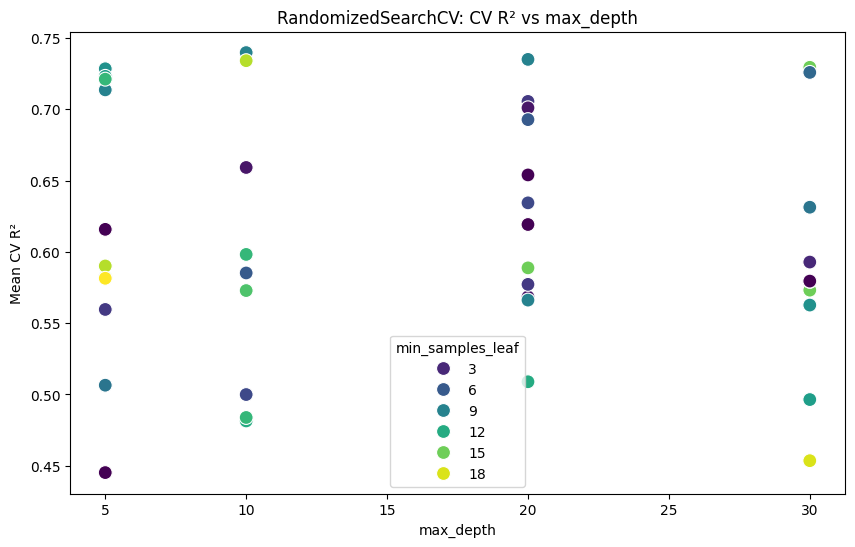

In [99]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=results, 
    x='param_DTC__max_depth', 
    y='mean_test_score', 
    hue='param_DTC__min_samples_leaf',  # optional: color by another hyperparam
    palette='viridis',
    s=100
)
plt.title('RandomizedSearchCV: CV R² vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Mean CV R²')
plt.legend(title='min_samples_leaf')
plt.show()
